In [1]:
import findspark
findspark.init()

# Movie recommender system with Spark machine learning


In this Jupyter notebook, you will use Spark and the Spark machine learning library to build a recommender system for movies with a data set from MovieLens. You'll also learn how to manage Spark performance.
Some familiarity with Python is recommended. 

## MovieLens

MovieLens is a project developed by GroupLens, a research laboratory at the University of Minnesota. MovieLens provides an online movie recommender application that uses anonymously-collected data to improve recommender algorithms. Anyone can try the app for free and get movies recommendations. To help people develop the best recommendation algorithms, MovieLens also released several data sets. In this notebook, you'll use the latest data set, which has two sizes.
The full data set consists of more than 24 million ratings across more than 40,000 movies by more than 250,000 users. The file size is kept under 1GB by using indexes instead of full string names.
The small data set that you'll use in this notebook is a subset of the full data set. It's generally a good idea to start building a working program with a small data set to get faster performance while interacting, exploring, and getting errors with your data. When you have a fully working program, you can apply the same code to the larger data set, possibly on a larger cluster of processors. You can also minimize memory consumption by limiting the data volume as much as possible, for example, by using indexes.

## Spark machine learning library
Apache Spark’s machine learning library makes practical machine learning scalable and easy. The library consists of common machine learning algorithms and utilities, including classification, regression, clustering, collaborative filtering (this notebook!), dimensionality reduction, lower-level optimization primitives, and higher-level pipeline APIs.
The library has two packages:
spark.mllib contains the original API that handles data in RDDs. It's in maintenance mode (deprecated), but fully supported.
spark.ml contains a newer API for constructing ML pipelines. It handles data in DataFrames. It's being actively enhanced.
You'll use the spark.ml package in this notebook.

## Table of contents

Load the data

1.1 Download the data from MovieLens

1.2 Load movies.csv

1.3 Load ratings.csv

Spark performance basics
Explore the data with Spark APIs
Visualize the data
Build the recommender system

5.1 Train the model

5.2 Run the model

5.3 Evaluate the model

5.4 Split the data set

5.5 Handle NaN results

5.6 Improve the performance score

5.7 Improve the model




In [2]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.getOrCreate()|

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/09/25 15:11:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load movies.csv
To load the movies.csv file into a Spark DataFrame.

In [5]:
movies = spark.read.format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat').option('header', 'true').option('inferSchema', 'true').load("data/SparkData/ml-latest-small/movies.csv")
movies.take(5)

[Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'),
 Row(movieId=2, title='Jumanji (1995)', genres='Adventure|Children|Fantasy'),
 Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance'),
 Row(movieId=4, title='Waiting to Exhale (1995)', genres='Comedy|Drama|Romance'),
 Row(movieId=5, title='Father of the Bride Part II (1995)', genres='Comedy')]

In [6]:
movies.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

## Load ratings.csv
load the ratings.csv file into a Spark DataFrame.

In [7]:
# Click here to create your ratings DataFrame
ratings = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true').option('inferSchema', 'true')\
  .load("data/SparkData/ml-latest-small/ratings.csv")
ratings.take(5)


[Row(userId=1, movieId=1, rating=4.0, timestamp=964982703),
 Row(userId=1, movieId=3, rating=4.0, timestamp=964981247),
 Row(userId=1, movieId=6, rating=4.0, timestamp=964982224),
 Row(userId=1, movieId=47, rating=5.0, timestamp=964983815),
 Row(userId=1, movieId=50, rating=5.0, timestamp=964982931)]

In [8]:
ratings.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



## Spark performance basics
Spark runs jobs in parallel on an executors cluster. You need a SparkSession instance to submit jobs. In Watson Studio, a SparkSession is automatically created, as spark.


Show the Spark version:

In [9]:
print(spark.version)

3.3.1


Show the default parallelism factor, which is the default number of partitions if you do not specify one:

In [10]:
sc=spark.sparkContext
print(sc.defaultParallelism)

8


see the details of the Spark configuration:

In [11]:
print(sc.getConf().toDebugString())

spark.app.id=local-1695679897387
spark.app.name=pyspark-shell
spark.app.startTime=1695679896135
spark.app.submitTime=1695679895943
spark.driver.extraJavaOptions=-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED
spark.driver.host=users-mbp-2.hsd1.ca.comcast.net
spark.driver.port=50832
spark.executor.extraJavaOptions=-XX:+Ig

Spark DataFrames are distributed collections across a cluster of Spark executors. One of the key factors for ensuring that a Spark job is well distributed across the cluster is the number of partitions for a DataFrame. Run the getNumPartitions() method to show the number of partitions for each DataFrame:

In [12]:
print('Number of partitions for the movies DataFrame: {}'.format(movies.rdd.getNumPartitions()))
print('Number of partitions for the ratings DataFrame: {}'.format(ratings.rdd.getNumPartitions()))

Number of partitions for the movies DataFrame: 1
Number of partitions for the ratings DataFrame: 1


Despite the defaultParallelism, the Spark DataFrameReader that we used only used a single Spark partition, which means all subsequent Spark operations would only run on a single executor.
You can run the repartition() method to redistribute the ratings data across multiple partitions. But be aware that repartition can involve a great deal of network bandwidth while data is transfered across the cluster! Because Spark DataFrames are immutable, you have to create a new DataFrame to repartition an existing DataFrame.
Create the repartitionedRatings DataFrame across 10 partitions:

In [13]:
repartitionedRatings = ratings.repartition(10)
print('Number of partitions for the ratings DataFrame: {}'.format(ratings.rdd.getNumPartitions()))
print('Number of partitions for the repartitionedRatings DataFrame: {}'.format(repartitionedRatings.rdd.getNumPartitions()))

Number of partitions for the ratings DataFrame: 1
Number of partitions for the repartitionedRatings DataFrame: 10


One of the key feature of Apache Spark is to leverage the memory as much as possible. While an action is in progress, data is loaded to memory and transformed several times before getting a result. But at the end of the processing, the memory is released. You can use the .cache() method to retain and persist a data set in memory as soon as you run an action on it.
Load the movies and ratings data sets in memory to improve performance:

In [14]:
print('Number of ratings: {}'.format(repartitionedRatings.count()))

Number of ratings: 100836


In [15]:
repartitionedRatings.cache()

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

When you run the next cell, count() is the first action performed on the repartitionedRatings DataFrame since it was cached. Thus, the data is read from object storage, the repartition() transformation is applied, and the count() action is run. But because you ran the cache() transformation on this DataFrame already, Spark won't release the memory.

In [16]:
print('Number of ratings: {}'.format(repartitionedRatings.count()))

Number of ratings: 100836


### Explore the data with Spark APIs

You'll use the Spark DataFrame API and SparkSQL to look at the data. The Spark DataFrame API and SparkSQL are high level APIs to query and transform Spark DataFrames.
Show the content of the DataFrame in a table:

In [17]:
movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [18]:
movies.show(5, truncate=False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



Print the schema of the DataFrame:

In [19]:
movies.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



By default, the schema shows every column as a string. To override this, you can either explicitly specify the schema or configure the inferSchema parameter in the Spark CSV DataFrameReader.
Set the inferSchema parameter and then print the schemas.
Use More option on upper right hand side panel (three dots) and insert project token.If this is the first time you are using a token in this project, you will receive message - No project access token. Below that message click on project settings and create token by clicking new token option from access tokens sections and then insert token in the notebook.

The token will get added to the first cell of your notebook. Copy that token to below cell and run it. You will then be able to use the get_file_url method to fetch a file from the object storage using Spark.

Run the describe() method to see the count, mean, standard deviation, minimum, and maximum values for the data in each column:


In [20]:
ratings.describe().show()

+-------+------------------+----------------+------------------+--------------------+
|summary|            userId|         movieId|            rating|           timestamp|
+-------+------------------+----------------+------------------+--------------------+
|  count|            100836|          100836|            100836|              100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|1.2059460873684695E9|
| stddev| 182.6184914635004|35530.9871987003|1.0425292390606342|2.1626103599513078E8|
|    min|                 1|               1|               0.5|           828124615|
|    max|               610|          193609|               5.0|          1537799250|
+-------+------------------+----------------+------------------+--------------------+



Not all of these statistics are actually meaningful!
You can use specific methods from the DataFrame API to compute any statistic:

In [21]:
print('Number of different users: {}'.format(ratings.select('userId').distinct().count()))
print('Number of different movies: {}'.format(ratings.select('movieId').distinct().count()))
print('Number of movies with at least one rating strictly higher than 4: {}'.format(ratings.filter('rating > 4').select('movieId').distinct().count()))

Number of different users: 610
Number of different movies: 9724
Number of movies with at least one rating strictly higher than 4: 4056


Spark version 2.0 is ANSI SQL-92 compliant and can run the 99 TPC-DS queries.

Find the number of movies with ratings higher than 4 again, this time with SQL:

In [22]:
ratings.createOrReplaceTempView('X')
spark.sql('SELECT COUNT(DISTINCT(movieId)) AS nb FROM X WHERE rating > 4').show()

+----+
|  nb|
+----+
|4056|
+----+



You can easily switch between Spark distributed DataFrames and pandas local DataFrames.

In [23]:
!pip install --upgrade pandas

In [24]:
import pandas as pd

ratings.toPandas().head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Visualize the data

You'll use the Seaborn and matplotlib matplotlib libraries to create graphs. The Seaborn library works with the matplotlib library to graph statistical data.

Install the Seaborn library:

In [25]:
!pip install --upgrade seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 5.4 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for matplotlib!=3.6.1,>=3.1 from https://files.pythonhosted.org/packages/30/5b/a6214caaa5adf07b52aecba98fdace32cc51e63a1fcc1f98d60ec128a6c0/matplotlib-3.8.0-cp310-cp310-macosx_10_12_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/fb/7f/c44a51a83a093bf5c84e07dd1e3cfe9f68c47b6499bd05a9de0c6dbdc2bc/contourpy-1.1.1-cp310-cp310-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/ad/33/b159873016ac8998d10212ef3ad9a28456452dcb9f963a21007403a0f81d/fonttools-4.42.1-cp310-cp310-macosx_10_9_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.0/151.0 kB 27.8 MB/s eta 0:00:00
  Obtaining dependency information for kiwisolver>=1.0.1 from https://files.pythonhosted.org/packages/0e/c1/d084f8edb26533a191415d5173

In [26]:
!pip install matplotlib

Create a graph of the movies reviewed by users:

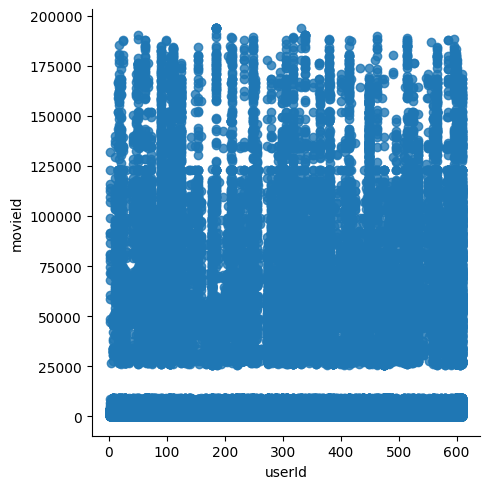

In [27]:
import seaborn as sns
%matplotlib inline

ratingsPandas = ratings.toPandas()
sns.lmplot(x='userId', y='movieId', data=ratingsPandas, fit_reg=False);

In [28]:
ratingsPandas.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


This matrix represents all the movies rated by users, but doesn't distinguish the ratings. Improve the graph by choosing a color palette to color the ratings:

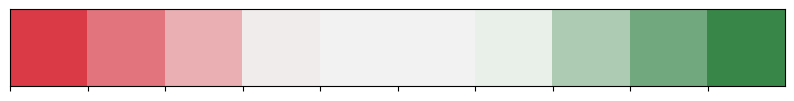

In [29]:
sns.palplot(sns.diverging_palette(10, 133, sep=80, n=10))

Create the graph on a larger scale with the color palette:

/Users/user/SparkVenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/user/SparkVenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


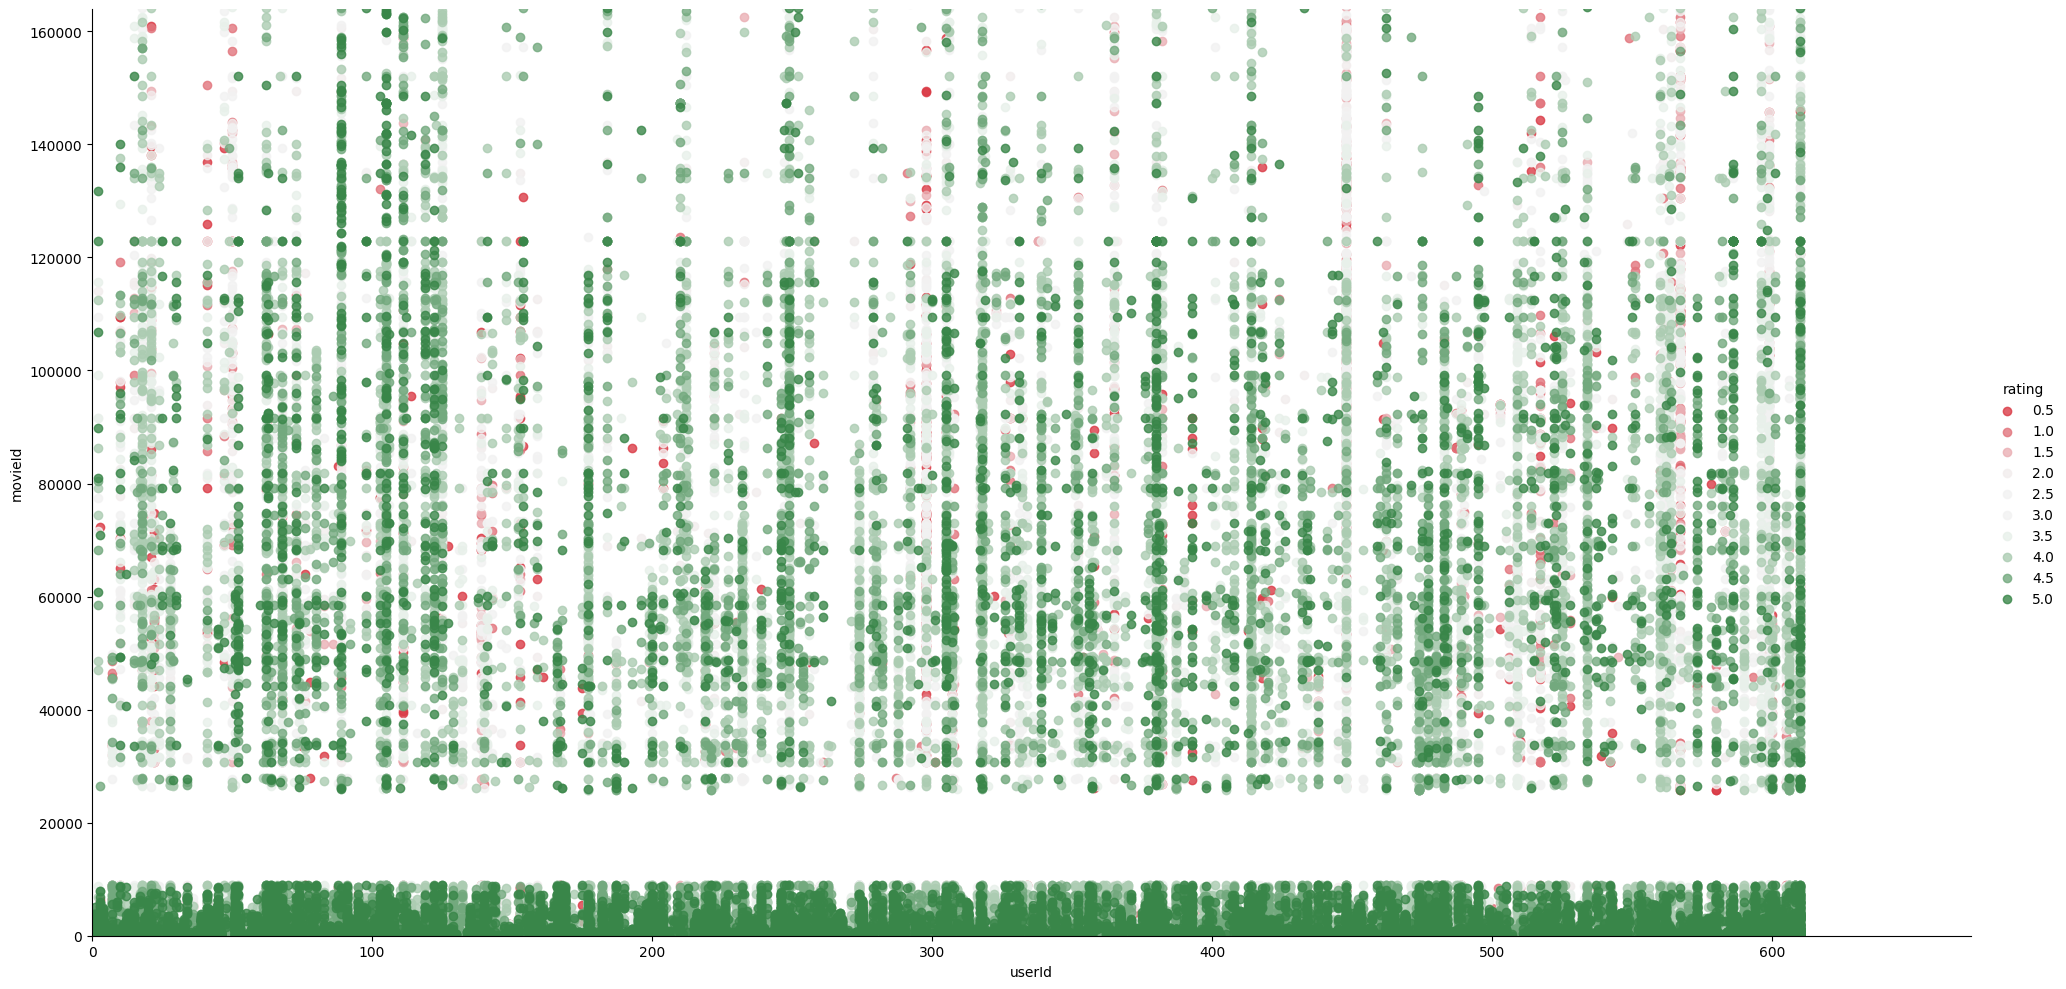

In [30]:
lm = sns.lmplot(x='userId', y='movieId', hue='rating', data=ratingsPandas, fit_reg=False, height=10, aspect=2, palette=sns.diverging_palette(10, 133, sep=80, n=10))
axes = lm.axes
axes[0, 0].set_ylim(0, 163949) # max movieId is 163949
axes[0, 0].set_xlim(0, 671) # max userId is 671
lm;

On this matrix, you'll notice gaps in the data: some movies and users seem to be missing. This could be because you're using a subset of the data (the small data set).

Nevertheless, you can identify some patterns. Some users always give positive reviews of movies. Some movies are rated a lot, which could be for different reasons, such as the first release of the MovieLens website had a much smaller catalog, or the movies are more famous.

Now visualize the global distribution of ratings with a violin plot:

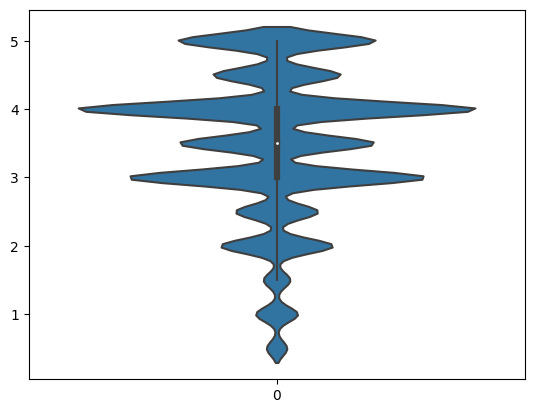

In [31]:
sns.violinplot([ratingsPandas.rating]);

In [33]:
ratingsPandas.groupby('movieId').count().sort_values(by='userId', ascending=False)

,userId,rating,timestamp
movieId,,,
356,329,329,329
318,317,317,317
296,307,307,307
593,279,279,279
2571,278,278,278
...,...,...,...
4093,1,1,1
4089,1,1,1
58351,1,1,1


In [34]:
movie_356 = ratingsPandas[ratingsPandas.movieId == 356]
movie_356.head()

,userId,movieId,rating,timestamp
20,1,356,4.0,964980962
725,6,356,5.0,845553200
880,7,356,5.0,1106635915
1053,8,356,3.0,839463527
1120,10,356,3.5,1455301685


/Users/user/SparkVenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/user/SparkVenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='rating', ylabel='userId'>

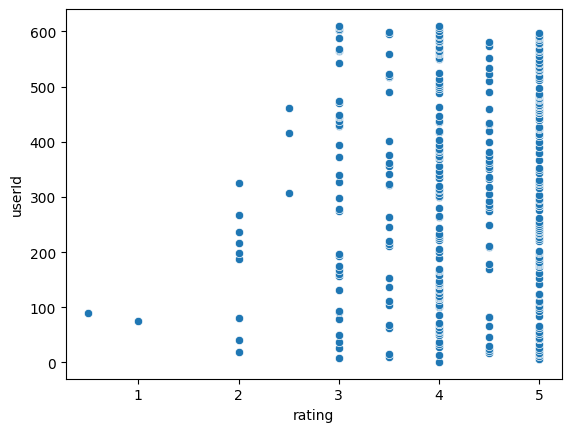

In [35]:
sns.scatterplot(x="rating", y = "userId", data = movie_356)

/Users/user/SparkVenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/user/SparkVenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/user/SparkVenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='rating', ylabel='count'>

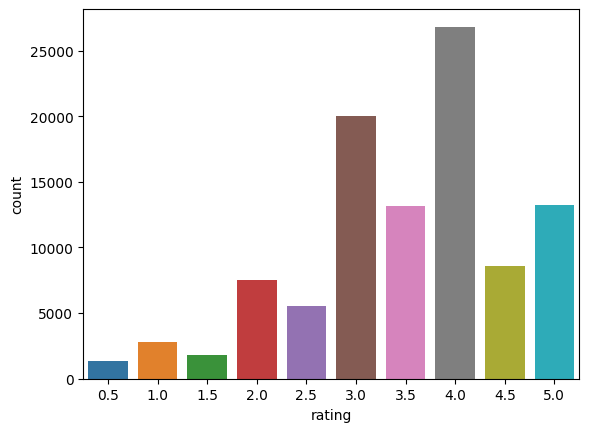

In [36]:
sns.countplot(x='rating', data=ratingsPandas)

### Build the recommender system

There are different methods for building a recommender system, such as, user-based, content-based, or collaborative filtering. Collaborative filtering calculates recommendations based on similarities between users and products. For example, collaborative filtering assumes that users who give the similar ratings on the same movies will also have similar opinions on movies that they haven't seen.

The alternating least squares (ALS) algorithm provides collaborative filtering between users and products to find products that the customers might like, based on their previous ratings.

In this case, the ALS algorithm will create a matrix of all users versus all movies. Most cells in the matrix will be empty. An empty cell means the user hasn't reviewed the movie yet. The ALS algorithm will fill in the probable (predicted) ratings, based on similarities between user ratings. The algorithm uses the least squares computation to minimize the estimation errors, and alternates between solving for movie factors and solving for user factors.
The following trivial example gives you an idea of the problem to solve. However, keep in mind that the general problem is much harder because the matrix often has far more missing values.



In [38]:
spark.sql('''
    SELECT *, 100 * nb_ratings/matrix_size AS percentage
    FROM (
        SELECT nb_users, nb_movies, nb_ratings, nb_users * nb_movies AS matrix_size
        FROM (
            SELECT COUNT(*) AS nb_ratings, COUNT(DISTINCT(movieId)) AS nb_movies, COUNT(DISTINCT(userId)) AS nb_users
            FROM X
        )
    )
''').toPandas().head()

,nb_users,nb_movies,nb_ratings,matrix_size,percentage
0,610,9724,100836,5931640,1.699968


Make sure all fields are numerical, numbers here may be string represented numbers, so convert to numerical type

In [39]:
ratings=ratings.selectExpr("cast(userId as int) userId", "cast(movieId as int) movieId",
"cast(rating as int) rating",
"cast(timestamp as int) timestamp")


In [40]:
ratings.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|     4|964982703|
|     1|      3|     4|964981247|
|     1|      6|     4|964982224|
|     1|     47|     5|964983815|
|     1|     50|     5|964982931|
|     1|     70|     3|964982400|
|     1|    101|     5|964980868|
|     1|    110|     4|964982176|
|     1|    151|     5|964984041|
|     1|    157|     5|964984100|
|     1|    163|     5|964983650|
|     1|    216|     5|964981208|
|     1|    223|     3|964980985|
|     1|    231|     5|964981179|
|     1|    235|     4|964980908|
|     1|    260|     5|964981680|
|     1|    296|     3|964982967|
|     1|    316|     3|964982310|
|     1|    333|     5|964981179|
|     1|    349|     4|964982563|
+------+-------+------+---------+
only showing top 20 rows



### Train the model

Use the SparkML ALS algorithm to train a model to provide recommendations. The mandatory parameters to the ALS algorithm are the columns that identify the users, the items, and the ratings. Run the fit() method to train the model:

In [41]:
from pyspark.ml.recommendation import ALS

model = ALS(userCol='userId', itemCol='movieId', ratingCol='rating').fit(ratings)

23/09/25 15:16:52 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/09/25 15:16:52 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/09/25 15:16:52 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


### Run the model

Run the transform() method to score the model and output a DataFrame with an additional prediction column that shows the predicted rating:

In [42]:
predictions = model.transform(ratings)
predictions.toPandas().head()

,userId,movieId,rating,timestamp,prediction
0,148,356,4,1482548476,3.560820
1,148,1197,3,1482548478,3.618653
2,148,4308,4,1482548613,3.467872
3,148,4886,3,1482548505,3.449340
4,148,4896,4,1482548717,3.365526



You can see that many of the predictions are close to the actual ratings.

### Evaluate the model

After you apply a model to a data set, you should evaluate the performance of the model by comparing the predicted values with the original values. Use the RegressionEvaluator method to compare continuous values with the root mean squared calculation. The root mean squared error (RMSE) calculation measures the average of the squares of the errors between what is estimated and the existing data. The lower the mean squared error value, the more accurate the model.

In [43]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
print('The root mean squared error for our model is: {}'.format(evaluator.evaluate(predictions)))

The root mean squared error for our model is: 0.6230241985981547


You want the performance score to improve with your design iterations so that the model is improved. But notice that you just ran the training and the scoring on the same data set. That's something that you won't normally do because you usually want to predict values that you don't already know! Therefore, this result is nonsense. To accurately evaluate the model, it's common practice in machine learning to split the data set between a training data set to train the model, and a test data set to compare the predicted results with the original results. This process is called cross-validation. Not doing cross-validation often leads to overfitting, which occurs when the model is too specific to the training data set and does not perform well on a more general data set. 


### Split the data set

Split your ratings data set between an 80% training data set and a 20% test data set. Then rerun the steps to train the model on the training set, run it on the test set, and evaluate the performance.





In [44]:
(trainingRatings, testRatings) = ratings.randomSplit([80.0, 20.0])

In [45]:
als = ALS(userCol='userId', itemCol='movieId', ratingCol='rating')
model = als.fit(trainingRatings)
predictions = model.transform(testRatings)

In [46]:
predictions.toPandas().head()

,userId,movieId,rating,timestamp,prediction
0,148,5816,4,1482548755,3.193085
1,148,30816,5,1482548570,3.111844
2,148,68954,4,1482548482,3.863783
3,148,69757,3,1482548519,3.586712
4,148,79132,1,1482548463,3.873082


In [47]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
print('The root mean squared error for our model is: {}'.format(evaluator.evaluate(predictions)))

The root mean squared error for our model is: nan


You might get the value nan (not a number) from the previous cell.

### Handle NaN results

A NaN result is due to SPARK-14489 and because the model can't predict values for users for which there's no data. A temporary workaround is to exclude rows with predicted NaN values or to replace them with a constant, for instance, the general mean rating. However, to map to a real business problem, the data scientist, in collaboration with the business owner, must define what happens if such an event occurs. For example, you can provide no recommendation for a user until that user rates a few items. Alternatively, before user rates five items, you can use a user-based recommender system that's based on the user's profile (that's another recommender system to develop).

Replace predicted NaN values with the average rating and evaluate the model:

In [48]:
avgRatings = ratings.select('rating').groupBy().avg().first()[0]
print ('The average rating in the dataset is: {}'.format(avgRatings))


The average rating in the dataset is: 3.350827085564679


In [49]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
print ('The root mean squared error for our model is: {}'.format(evaluator.evaluate(predictions.na.fill(avgRatings))))

The root mean squared error for our model is: 0.9469698869543629


Now exclude predicted NaN values and evaluate the model:

In [50]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
print ('The root mean squared error for our model is: {}'.format(evaluator.evaluate(predictions.na.drop())))


The root mean squared error for our model is: 0.9340368925084157


Obviously, you get lower performance than with the previous model, but you're protected against overfitting: you will actually get this level of performance on new incoming data!

### Improve the performance score

If you run the randomSplit(), fit(), transform(), and evaluate() functions several times, you won't always get the same performance score. This is because the randomSplit() and ALS() functions have some randomness. To get a more precise performance score, run the model several times and then compute the average performance score. This process is really close to what is called  k-fold cross validation.

Create a repeatALS() function that trains, runs, and evaluates the model multiple times:

In [51]:
def repeatALS(data, k=3, userCol='userId', itemCol='movieId', ratingCol='rating', metricName='rmse'):
    evaluations = []
    for i in range(0, k):  
        (trainingSet, testingSet) = data.randomSplit([k - 1.0, 1.0])
        als = ALS(userCol=userCol, itemCol=itemCol, ratingCol=ratingCol)
        model = als.fit(trainingSet)
        predictions = model.transform(testingSet)
        evaluator = RegressionEvaluator(metricName=metricName, labelCol='rating', predictionCol='prediction')
        evaluation = evaluator.evaluate(predictions.na.drop())
        print('Loop {}: {} = {}'.format(i + 1, metricName, evaluation))
        evaluations.append(evaluation)
    return sum(evaluations) / float(len(evaluations))

Run repeatALS four times and average the performance scores:

In [52]:
print('RMSE = {}'.format(repeatALS(ratings, k=4)))

Loop 1: rmse = 0.9333760742609273
Loop 2: rmse = 0.9420466341624935
Loop 3: rmse = 0.9335854246910648
Loop 4: rmse = 0.9415023744844533
RMSE = 0.9376276268997348


The computed performance score is more stable this way.

Create a kfoldALS() function that also trains, runs, and evaluates the model, but splits up the data between training and testing data sets in a different way. The original data set is split into k data sets. Each of the k iterations of the function uses a different data set for testing and the other data sets for training.

In [53]:
def kfoldALS(data, k=3, userCol='userId', itemCol='movieId', ratingCol='rating', metricName='rmse'):
    evaluations = []
    weights = [1.0] * k
    splits = data.randomSplit(weights)
    for i in range(0, k):  
        testingSet = splits[i]
        trainingSet = spark.createDataFrame(sc.emptyRDD(), data.schema)
        for j in range(0, k):
            if i == j:
                continue
            else:
                trainingSet = trainingSet.union(splits[j])
        als = ALS(userCol=userCol, itemCol=itemCol, ratingCol=ratingCol)
        model = als.fit(trainingSet)
        predictions = model.transform(testingSet)
        evaluator = RegressionEvaluator(metricName=metricName, labelCol='rating', predictionCol='prediction')
        evaluation = evaluator.evaluate(predictions.na.drop())
        print('Loop {}: {} = {}'.format(i + 1, metricName, evaluation))
        evaluations.append(evaluation)
    return sum(evaluations) / float(len(evaluations))

Compute the average performance score for 4 folds:

In [54]:
print('RMSE = {}'.format(kfoldALS(ratings, k=4)))

Loop 1: rmse = 0.9367560285286562
Loop 2: rmse = 0.9351603951976148
Loop 3: rmse = 0.9302278326941525
Loop 4: rmse = 0.9429509847128216
RMSE = 0.9362738102833114


Compute the average performance score for 10 folds:

In [55]:
print('RMSE = {}'.format(kfoldALS(ratings, k=10)))

Loop 1: rmse = 0.9057001332797724
Loop 2: rmse = 0.9152639336978874


Loop 3: rmse = 0.9044118745574573
Loop 4: rmse = 0.9090746639188633


Loop 5: rmse = 0.9161618910876999
Loop 6: rmse = 0.9226456062217501
Loop 7: rmse = 0.9180835555750164
Loop 8: rmse = 0.9057790993645252
Loop 9: rmse = 0.9140770469443391


Loop 10: rmse = 0.945621551555437
RMSE = 0.9156819356202748


Recall that you want to minimize the RMSE. And that 10 folds means a training set of 90% of the data, while 4 folds means a training training set of 75% of the data. If you choose a value too small for  k
 , you will run into the selection bias issue. On the other hand, too big value for  k
 means overfitting - high variance and low bias. Therefore, choosing the right  k
  is important. Usually, the recommended value of  k
  is between 5 and 10, however, this can change based on the data set.

### Improve the model

So now, how can you improve this model? Machine learning algorithms have hyperparameters that control how the algorithm works.

The ALS algorithm has this signature:

class pyspark.ml.recommendation.ALS(

        rank=10,
        maxIter=10,
        regParam=0.1,
        numUserBlocks=10,
        numItemBlocks=10,
        implicitPrefs=false,
        alpha=1.0,
        userCol="user",
        itemCol="item",
        seed=None,
        ratingCol="rating",
        nonnegative=false,
        checkpointInterval=10,
        intermediateStorageLevel="MEMORY_AND_DISK",
        finalStorageLevel="MEMORY_AND_DISK"
    )
    
The ALS hyperparameters are:

rank = the number of latent factors in the model

maxIter = the maximum number of iterations

regParam = the regularization parameter

To test several values for those hyperparameters and choose the best configuration, it's common practice to define a grid of parameter combinations and to run a grid search over the combinations to evaluate the resulting models and comparing their performance. This process is known as model selection.

In [56]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

(trainingRatings, validationRatings) = ratings.randomSplit([80.0, 20.0])
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

paramGrid = ParamGridBuilder().addGrid(als.rank, [1, 5, 10]).addGrid(als.maxIter, [20]).addGrid(als.regParam, [0.05, 0.1, 0.5]).build()

crossval = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
cvModel = crossval.fit(trainingRatings)

predictions = cvModel.transform(validationRatings)

print('The root mean squared error for our model is: {}'.format(evaluator.evaluate(predictions.na.drop())))



The root mean squared error for our model is: 0.9899584336391453


The more folds and parameters you add to the grid, the longer it takes to test any combination. The CrossValidator model contains more information about the performance for each combination that you can get with the avgMetrics() method. For example, you can graph the results on a plot for analysis.
Unfortunately, because of the SPARK-14489 issue mentioned above, the CrossValidator function can't compute the root mean squared error most of the time and provides incorrect results. You could limit this problem by making the training set much larger than the test set, but that's not a good practice. If you want to learn more about this issue, which is more a conceptual one than a technical one, you can have a look at Nick Pentreath's pull request #12896(https://github.com/apache/spark/pull/12896). Welcome to the Open Source world!


In [57]:
from pyspark.sql.functions import lit

def recommendMovies(model, user, nbRecommendations):
    # Create a Spark DataFrame with the specified user and all the movies listed in the ratings DataFrame
    dataSet = ratings.select('movieId').distinct().withColumn('userId', lit(user))

    # Create a Spark DataFrame with the movies that have already been rated by this user
    moviesAlreadyRated = ratings.filter(ratings.userId == user).select('movieId', 'userId')

    # Apply the recommender system to the data set without the already rated movies to predict ratings
    predictions = model.transform(dataSet.subtract(moviesAlreadyRated)).dropna().orderBy('prediction', ascending=False).limit(nbRecommendations).select('movieId', 'prediction')

    # Join with the movies DataFrame to get the movies titles and genres
    recommendations = predictions.join(movies, predictions.movieId == movies.movieId).select(predictions.movieId, movies.title, movies.genres, predictions.prediction)

#     recommendations.show(truncate=False)
    return recommendations

In [58]:
dataSet = ratings.select('movieId').distinct().withColumn('userId', lit(133))
dataSet.show(10)

+-------+------+
|movieId|userId|
+-------+------+
|   1580|   133|
|   2366|   133|
|   3175|   133|
|   1088|   133|
|  32460|   133|
|  44022|   133|
|  96488|   133|
|   1238|   133|
|   1342|   133|
|   1591|   133|
+-------+------+
only showing top 10 rows



In [59]:
print('Recommendations for user 133:')
recommendMovies(model, 133, 10).toPandas()

Recommendations for user 133:


,movieId,title,genres,prediction
0,1066,Shall We Dance (1937),Comedy|Musical|Romance,3.645945
1,1939,"Best Years of Our Lives, The (1946)",Drama|War,3.600702
2,3022,"General, The (1926)",Comedy|War,3.701411
3,4429,Moby Dick (1956),Drama,3.630578
4,4495,Crossing Delancey (1988),Comedy|Romance,3.642001
5,8477,"Jetée, La (1962)",Romance|Sci-Fi,4.029972
6,25771,"Andalusian Dog, An (Chien andalou, Un) (1929)",Fantasy,3.894790
7,33649,Saving Face (2004),Comedy|Drama|Romance,3.984485
8,171495,Cosmos,(no genres listed),3.786467
9,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama,3.714195


In [60]:
print('Recommendations for user 471:')
recommendMovies(model, 471, 10).toPandas()

Recommendations for user 471:


,movieId,title,genres,prediction
0,1096,Sophie's Choice (1982),Drama,4.504837
1,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,4.508382
2,1411,Hamlet (1996),Crime|Drama|Romance,5.149443
3,3925,Stranger Than Paradise (1984),Comedy|Drama,4.469823
4,4002,"Planes, Trains & Automobiles (1987)",Comedy,4.597925
5,26052,Pickpocket (1959),Crime|Drama,4.427556
6,26171,Play Time (a.k.a. Playtime) (1967),Comedy,5.157216
7,33649,Saving Face (2004),Comedy|Drama|Romance,4.536448
8,73023,Crazy Heart (2009),Drama|Romance,4.465259
9,171495,Cosmos,(no genres listed),4.477582


In [61]:
print('Recommendations for user 496:')
recommendMovies(model, 496, 10).toPandas()

Recommendations for user 496:


,movieId,title,genres,prediction
0,2360,"Celebration, The (Festen) (1998)",Drama,4.726281
1,3925,Stranger Than Paradise (1984),Comedy|Drama,5.038035
2,4356,Gentlemen Prefer Blondes (1953),Comedy|Musical|Romance,5.193271
3,7579,Pride and Prejudice (1940),Comedy|Drama|Romance,4.827781
4,7767,"Best of Youth, The (La meglio gioventù) (2003)",Drama,5.134131
5,8477,"Jetée, La (1962)",Romance|Sci-Fi,4.853522
6,26810,Bad Boy Bubby (1993),Drama,5.065870
7,47423,Half Nelson (2006),Drama,4.724663
8,51931,Reign Over Me (2007),Drama,4.807265
9,71899,Mary and Max (2009),Animation|Comedy|Drama,4.853738
